# Introduction - Recipe Ingredients Analysis

This **unsupervised learning** (USL) project uses the [recipe ingredients dataset](https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset) from the former kaggle competition "Whats Cooking?". The dataset contains the ingredients of roughly **40.000 recipes**, provided by the US recipe repository "yummly".
The initial goal of the competition was to predict the "cuisine" (i.e. italian, chinese, southern us, ...) based on the list of ingredients. This project focuses on using the dataset to demonstrate unsupervised learning methods. However, a supervised learning baseline is trained and compared to the predictions from an unsupervised algorithm.

The **key take-aways** are:
* If you have labels, use them! ("KNN vs. KMeans")
* Textbook USL methods might not work on all kinds of data. ("elbow method")
* USL methods can still provide interesting insights even for labelled data. ("explainable AI for clustering algorithms")

# Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from scipy.stats import ttest_ind

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

# EDA and Feature Engineering Part 1

The labelled part of the dataset (train.json) consists of 39.774 different recipes of 20 cuisines, containing 6.714 unique ingredients. The dataset is quite imbalanced in terms of labels, where the six most frequent cuisins (i.e. "italian", "mexican", "french", "southern_us", "chinese", "indian") make up for around 67% of the data. The large number of unique ingredients (i.e. **high dimensionality**) and **imbalanced classes** are something that needed to be adressed if the goal were to train supervised learning classifiers with maximum accuracy. Since the number of unique ingredients per recipe is strongly correlated with the number of individual recipes, it is not possible to draw conclusions about the "diversity" of different cuisines. However, the cuisines can be manually assigned to regions to compensate for the imbalanced cuisine occurence. A histogram (or density plot) shows that **the three most frequent regions (Asia, Europe and North America) show a different distribution of unique ingredients per recipe**, with North America having the lowest and Asia the highest ingredient count per recipe, respectively. The difference is also **statistically significant** (p=0 for all pairwise comparisons).

In [2]:
df = pd.read_json('train.json')
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
# number of unique recipes: 39773
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [4]:
# denormalize df
df_denorm = df.explode("ingredients").rename(columns={"ingredients": "ingredient"})
df_denorm.head(5)

,id,cuisine,ingredient
0,10259,greek,romaine lettuce
0,10259,greek,black olives
0,10259,greek,grape tomatoes
0,10259,greek,garlic
0,10259,greek,pepper


In [5]:
# how many unique ingredients in total? -> 6714
len(df_denorm.ingredient.unique()) 

6714

In [6]:
# how many unique ingredients per cuisine? Which cuisines are the "richest"
df_grouped = df_denorm.groupby(by="cuisine").nunique()\
                .rename(columns={"ingredient": "unique ingredients", "id": "id (count)"})\
                .sort_values(by=["unique ingredients"], ascending=False)
df_grouped.head(5) # top 5 unique ingredients

,id (count),unique ingredients
cuisine,,
italian,7838,2929
mexican,6438,2684
southern_us,4320,2462
french,2646,2102
chinese,2673,1792


In [7]:
df_grouped.corr(method="spearman") # strong rank correlation between count and unique ingredients -> no real information on "most diverse" cuisine!

,id (count),unique ingredients
id (count),1.000000,0.957895
unique ingredients,0.957895,1.000000


In [8]:
df_grouped_ID = df_denorm.groupby(by="id").count()\
            .drop(["cuisine"], axis=1).rename(columns={"ingredient": "ingredients (count)"})\
            .join(df.set_index("id")).drop(["ingredients"], axis=1)
df_grouped_ID

,ingredients (count),cuisine
id,,
0,11,spanish
1,18,mexican
2,18,french
3,11,chinese
4,4,italian
...,...,...
49712,10,indian
49713,15,southern_us
49714,13,irish


Count of most frequent cuisines:  26918


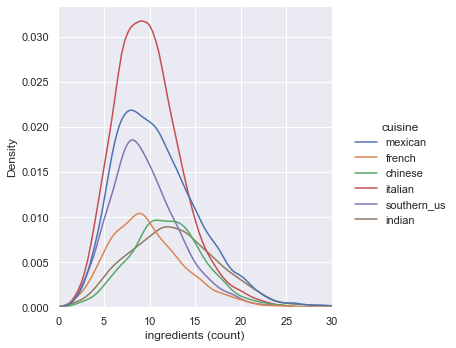

In [9]:
df_grouped_ID_filt = df_grouped_ID[df_grouped_ID.cuisine.isin(["italian", "mexican", "french", "southern_us", "chinese", "indian"])]
print("Count of most frequent cuisines: ", len(df_grouped_ID_filt))
sns.set(rc={'figure.figsize':(12,8)})
sns.displot(df_grouped_ID_filt, x="ingredients (count)", hue="cuisine", kind="kde")
plt.xlim(0, 30);
# number of ingredients appear to be typical of continental region (USMCA, EUROPE, ASIA)

In [10]:
# Lets see if  the mean number of unique ingredients is statistically significant!
def map_cuisine_to_region(country_name):
    country_dict = {
      "italian": "Europe",
      "mexican": "North America",
      "southern_us": "North America",
      "french": "Europe",
      "chinese": "Asia", 
      "indian":  "Asia", 
      "cajun_creole": "LatAm",
      "japanese": "Asia", 
      "thai":  "Asia", 
      "spanish": "Europe",
      "greek": "Europe",
      "british": "Europe",
      "vietnamese": "Asia", 
      "irish": "Europe",
      "moroccan": "Africa", 
      "filipino": "Asia", 
      "korean": "Asia", 
      "jamaican": "LatAm",
      "russian": "Russia",
      "brazilian": "LatAm"
    }
    return country_dict[country_name]
df_grouped_ID["Region"] = df_grouped_ID["cuisine"].apply(map_cuisine_to_region)
df_grouped_ID

,ingredients (count),cuisine,Region
id,,,
0,11,spanish,Europe
1,18,mexican,North America
2,18,french,Europe
3,11,chinese,Asia
4,4,italian,Europe
...,...,...,...
49712,10,indian,Asia
49713,15,southern_us,North America
49714,13,irish,Europe


(0.0, 30.0)

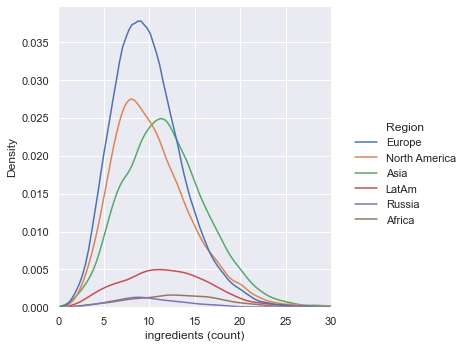

In [11]:
# Plot ingredients count per recipe by region
sns.set(rc={'figure.figsize':(12,8)})
sns.displot(df_grouped_ID, x="ingredients (count)", hue="Region", kind="kde")
plt.xlim(0, 30)

In [14]:
# t-test for difference in means for count data
print("Europe vs. Asia difference in means: \n",
ttest_ind(df_grouped_ID[df_grouped_ID["Region"]=="Europe"]["ingredients (count)"], 
          df_grouped_ID[df_grouped_ID["Region"]=="Asia"]["ingredients (count)"]))
print("Europe vs. North America difference in means: \n",
ttest_ind(df_grouped_ID[df_grouped_ID["Region"]=="Europe"]["ingredients (count)"], 
          df_grouped_ID[df_grouped_ID["Region"]=="North America"]["ingredients (count)"]))
print("Asia vs. North America difference in means: \n",
ttest_ind(df_grouped_ID[df_grouped_ID["Region"]=="Asia"]["ingredients (count)"], 
          df_grouped_ID[df_grouped_ID["Region"]=="North America"]["ingredients (count)"]))

Europe vs. Asia difference in means: 
 Ttest_indResult(statistic=-35.76743347457227, pvalue=2.4606394613468414e-273)
Europe vs. North America difference in means: 
 Ttest_indResult(statistic=-8.850676976261619, pvalue=9.26564200555166e-19)
Asia vs. North America difference in means: 
 Ttest_indResult(statistic=23.821721141003554, pvalue=7.595073980932345e-124)


# Data Cleaning and Feature Engineering Part 2

Looking at the ingredients, it becomes clear that there are many "**subtypes**" that make the dimensionality of the dataset explode (i.e. salt -> salt, sea salt, kosher salt, fine sea salt, coarse salt, etc.). On the one hand, those subtypes may be very important for recipe classification (take for example, italian seasoning vs. creole seasoning). However, the algorithms propsed here suffer from the "**curse of dimensionality**", and the large feature space leads to memory problems that needed to be adressed (i.e. by using scipy sparse matrices) if no dimensionality reduction technique were to be applied.
Therefore, the ingredients are "**downsampled**" by using string manipulation. This method is quite **error-prone** (i.e. "unsalted butter" becomes "salt"), but it reduces the number of unique ingredients by roughly 67% and therefore the erroneous transformations are accepted for now. In the future, using **memory-efficient sparse matrices** may be compared to the results of the transformed ingredients.

As a final pre-processing and feature engineering step, the ingredient data is **one hot encoded**.

In [12]:
# Feature Engineering
# duplicate ingredients (from https://www.kaggle.com/code/fritzpassow/recipe-ingredients-analysis)
# also reduces memory
ingr = pd.Series(df_denorm.ingredient.unique())
print("Number of unique ingredients: " + str(len(ingr)))
print("---")
dupes_dict = dict()
print_count = 0
i_count = 0
for i in ingr:
    if i == "rape" or i == "black":
        continue
    else:
        dupes = ingr[ingr.str.contains(i)]
        if len(dupes) > 12:
            i_count += 1
            for dupe in dupes.unique().tolist():            
                dupes_dict[dupe] = i
            if print_count < 5:
                print(i, "->", str(dupes.unique().tolist()))
                print("\n")
                print_count += 1
print(i_count)

Number of unique ingredients: 6714
---
garlic -> ['garlic', 'garlic powder', 'garlic paste', 'garlic cloves', 'garlic chili sauce', 'crushed garlic', 'large garlic cloves', 'chopped garlic', 'minced garlic', 'garlic salt', 'chili paste with garlic', 'garlic puree', 'granulated garlic', 'chili garlic paste', 'fried garlic', 'roasted garlic', 'garlic pepper seasoning', 'garlic juice', 'garlic flakes', 'diced tomatoes with garlic and onion', 'knorr garlic minicub', 'garlic chives', 'green garlic', 'black bean sauce with garlic', 'garlic mayonnaise', 'garlic bulb', 'chilegarlic sauce', 'clove garlic, fine chop', 'dried minced garlic', 'chile paste with garlic', 'Gourmet Garden garlic paste', 'garlic shoots', 'Thai chili garlic sauce', 'garlic oil', 'black bean garlic sauce', 'knorr italian side   creami garlic shell', 'wild garlic', 'garlic bread', 'garlic naan', 'garlic and herb seasoning', 'powdered garlic', 'garlic sauce', 'flowering garlic chives', 'garlic herb feta', 'garlic olive oil

C:\Users\Z0145963\AppData\Local\Temp/ipykernel_10880/2442834998.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  dupes = ingr[ingr.str.contains(i)]


157


In [13]:
def map_frequent_ingredients(ing):
    try:
        updated_ing = dupes_dict[ing]
    except:
        updated_ing = ing
    return updated_ing

df_denorm["ing_simple"] = df_denorm["ingredient"].apply(map_frequent_ingredients)
df_denorm

,id,cuisine,ingredient,ing_simple
0,10259,greek,romaine lettuce,lettuce
0,10259,greek,black olives,olives
0,10259,greek,grape tomatoes,tomatoes
0,10259,greek,garlic,garlic
0,10259,greek,pepper,pepper
...,...,...,...,...
39773,2362,mexican,garlic,garlic
39773,2362,mexican,white sugar,sugar
39773,2362,mexican,roma tomatoes,tomatoes
39773,2362,mexican,celery,celery


In [14]:
# unique ingredients: 6714
# unique "simple" ingredients: 2346
len(df_denorm.ing_simple.unique()) 

2346

In [15]:
# One-Hot Encoding of Ingredients (simple)
df_feat = df_denorm.copy()
df_feat.reset_index(inplace=True, drop=True)
df_onehot = pd.get_dummies(df_feat["ing_simple"])
df_onehot = df_feat.join(df_onehot)
df_onehot = df_onehot.groupby(by="id").sum().reset_index()
df_onehot = df_onehot.join(df_grouped_ID, on="id", lsuffix='_left', rsuffix='_right').set_index("id")
df_onehot

,( oz.) tomato paste,7 Up,Accent Seasoning,Adobo All Purpose Seasoning,Alexia Waffle Fries,Amaretti Cookies,Anaheim chile,Angostura bitters,Argo Corn Starch,Azteca Flour Tortillas,...,yuzu,za'atar,zest,zinfandel,ziti,zucchini,zucchini blossoms,ingredients (count),cuisine,Region
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,spanish,Europe
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,18,mexican,North America
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,18,french,Europe
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,11,chinese,Asia
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,italian,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,indian,Asia
49713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,15,southern_us,North America
49714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,13,irish,Europe


In [16]:
# Sanity check for OHE, value should be 0
assert (sum(df_onehot.iloc[:,:2346].sum(axis=1) != df_onehot["ingredients (count)"])) == 0

# Train-Test Split and Baseline

Standard 80:20 train-test split is applied to the data. As a **baseline classifier, KNN is trained and tuned** with a linear grid search. Interestlingy, k=1 yields almost 100% accuracy on the training set and still 71% on the test set.

In [17]:
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [18]:
df_train = df_onehot.sample(frac=0.8,random_state=200) #random state is a seed value
df_test = df_onehot.drop(df_train.index)

X_train = df_train.iloc[:,:2346].to_numpy()
y_train = df_train.iloc[:,2348].to_numpy() # 2347: cuisine, 2348: Region

X_test = df_test.iloc[:,:2346].to_numpy()
y_test = df_test.iloc[:,2348].to_numpy() # 2347: cuisine, 2348: Region

In [19]:
# Use knn as baseline supervised learning classifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
baseline_acc_train = neigh.score(X_train, y_train)
baseline_acc_test = neigh.score(X_test, y_test)
print("Training set accuracy: {:.3f}%".format(baseline_acc_train))
print("Test set accuracy: {:.3f}%".format(baseline_acc_test))

Training set accuracy: 0.856%
Test set accuracy: 0.736%


In [22]:
# hyperparameter tuning
def grid_search_KNN(k_max):
    highest_acc = 0.0
    best_k = 1
    all_accs = []
    best_clf = None
    print("Tuning KNN hyperparameter from k=1 to k={0:.0f}...".format(k_max))
    for i in range(1, k_max+1):
        clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X_train, y_train)
        this_acc = clf.score(X_train, y_train)
        if this_acc > highest_acc:
            highest_acc = this_acc
            best_k = i
            best_clf = clf
        print("\tCurrent training set accuracy (k={0:.0f}): {1:.3f}%".format(i, this_acc))
        all_accs.append(this_acc)
    print("Best training set accuracy (k={0:.0f}): {1:.3f}%".format(best_k, highest_acc))
    return best_clf

neigh_opt = grid_search_KNN(5)

baseline_acc_train = neigh_opt.score(X_train, y_train)
baseline_acc_test = neigh_opt.score(X_test, y_test)
print("Training set accuracy: {:.3f}%".format(baseline_acc_train))
print("Test set accuracy: {:.3f}%".format(baseline_acc_test))

Tuning KNN hyperparameter from k=1 to k=5...
	Current training set accuracy (k=1): 0.998%
	Current training set accuracy (k=2): 0.863%
	Current training set accuracy (k=3): 0.856%
	Current training set accuracy (k=4): 0.837%
	Current training set accuracy (k=5): 0.827%
Best training set accuracy (k=1): 0.998%
Training set accuracy: 0.998%
Test set accuracy: 0.713%


# Unsupervised Learning Approaches

In this section, USL algorithms are applied on the dataset. Firstly, **KMeans clustering** is used to predict the region of the recipe, allowing for a direct **comparison with its supervised learning counterpart KNN**. The results here are very clear: KNN outperforms KMeans by an enormous margin! Also, there are two more issues with KMeans for this task:
* This kind of algorithm is very prone to the **curse of dimensionality**, so the runtime using over 2.000 features is quite high. **PCA** is a required pre-processing step here.
* The `label_permute_compare` function from the lecture has `n!` possible permutations, so this approach is only possible for a **small number of classes**. In fact, it is one of the reasons why the region of the recipe was used instead of the original task (i.e. cuisine).

The huge accuracy difference, as well as the problems stated above, lead to the first key take-away from this project:

> **If you have labels, use them!** (unless you can't trust the labelled data or want to dig deeper on subsets)

In the next step, the total number of classes is determined independently of the target labels, making it an **actual USL task**. Here, the very popular elbow method is used to determine the ideal number of clusters. Here, we see another issue that is not specific to this dataset, but actually quite frequent in practice: The distortion of KMeans **decreases without a salient elbow shape** and therefore, the method fails to suggest an "ideal" number of clusters. Hence, the second key take-away is:

> **Textbook USL methods** might not work on all kinds of data.

However, clustering methods can be analyised by another way - the "**explainable AI** way". It is still possible to draw meaningful conclusions about the clusters by looking at **characteristic cluster properties**. In the case of the recipe dataset, the **most frequent ingredients for each cluster** are determined and also the **cluster homogenity** is visualized. Although there are clusters with no meaningful interpretation, the following interesting aspects can be found:
* Cluster 0 (the "European" cluster) -> parsley, tomatoes, salt, cheese, pepper, red, mi, butter, garlic, olive oil
* Cluster 2 (the "Asian" cluster) -> red, water, gin, pepper, salt, garlic, oil, soy, sesame, sugar
* Cluster 3 (the "Pastry" cluster) -> cream, baking powder, large eggs, butter, salt, flour, mi, extra, sugar, water

Hence, the thrird take-away for this project is:

> USL methods can still provide interesting insights (even for labelled data) when using **explainable AI**.

In [33]:
# Code from Peer Week 2

# Get best label permutation
def label_permute_compare(ytdf, yp):
    unique_labels = ytdf.Region.unique()
    n = len(unique_labels)
    perm = itertools.permutations(range(n), n)
    best_acc = 0.0
    best_pair = tuple([0]*n)
    for enc in perm:
        enc_dict = dict(zip(unique_labels, enc))
        ytdf_copy = ytdf.copy()
        ytdf_copy["labels"] = ytdf_copy["Region"].apply(lambda x: enc_dict[x])
        y_true = ytdf_copy["labels"].values
        y_pred = yp
        acc_score = accuracy_score(y_true, y_pred)
        if acc_score > best_acc:
            best_pair = enc
            best_acc = acc_score
    return (best_pair, best_acc)

# Get confusion matrix
def get_confusion_matrix(ytdf, labelorder, yp):
    ytdf_copy = ytdf.copy()
    unique_labels = ytdf.Region.unique() # to list
    enc_dict = dict(zip(unique_labels, labelorder))
    ytdf_copy["labels"] = ytdf_copy["Region"].apply(lambda x: enc_dict[x])
    y_true = ytdf_copy["labels"].values
    y_pred = yp
    return confusion_matrix(y_true, y_pred)

## KMeans Clustering to predict target label

In [24]:
# Use PCA because of "curse of dimensionality" associated with KMeans
pca = PCA(n_components=250)
X_train_red = pca.fit_transform(X_train)
print("X_train (before PCA):", X_train.shape, "\nX_train_red (after PCA): ", X_train_red.shape)
print("PCA explained variance ratio: {:.2f}".format(pca.explained_variance_ratio_.sum()))

X_train (before PCA): (31819, 2346) 
X_train_red (after PCA):  (31819, 250)
PCA explained variance ratio: 0.94


In [25]:
kmeans_orig = KMeans(n_clusters=len(df_train.Region.unique())).fit(X_train)
kmeans_orig_red = KMeans(n_clusters=len(df_train.Region.unique())).fit(X_train_red)

In [26]:
kmeans_orig_labelorder, kmeans_orig_acc = label_permute_compare(df_train, kmeans_orig.labels_)
print("KMeans training set accuracy (before PCA): {:.3f}%".format(kmeans_orig_acc))

kmeans_orig_labelorder_red, kmeans_orig_acc_red = label_permute_compare(df_train, kmeans_orig_red.labels_)
print("KMeans training set accuracy (after PCA): {:.3f}%".format(kmeans_orig_acc_red))

KMeans training set accuracy (before PCA): 0.332%
KMeans training set accuracy (after PCA): 0.332%


In [41]:
prnt_str = ""
for reg, idx in zip(df_train.Region.unique(), kmeans_orig_labelorder):
    prnt_str += (reg + ": " + str(idx) + " | ")
print(prnt_str)
get_confusion_matrix(df_train, kmeans_orig_labelorder, kmeans_orig.labels_)

Asia: 3 | North America: 5 | Europe: 4 | LatAm: 1 | Africa: 2 | Russia: 0 | 


array([[ 137,  137,    6,    0,   10,  113],
       [ 197, 1045,  159,   45,   76,  523],
       [  37,  231,  227,    1,    4,  168],
       [ 445,  843, 2136, 3244,   39, 2082],
       [1684, 3079,  469,   12, 2853, 3183],
       [1477, 2116, 1481,   34,  484, 3042]], dtype=int64)

## KMeans Clustering without prediction

### Determine optimal k by elbow-Method

In [58]:
# Distortion (mean of square distance) vs. values of k to optimize n_clusters
# https://stackoverflow.com/questions/41540751
def hptune_kmeans(X, k_max):
    distortions = []
    print("Tuning KMeans n_clusters from k=2 to k={0:.0f}...".format(k_max))
    for k in range(2, k_max+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        this_distortion = kmeans.inertia_
        distortions.append(this_distortion)
        print("\tCurrent distortion (k={0:.0f}): {1:.0f}".format(k, this_distortion))
    return distortions

k_hp_max = 20
distortions = hptune_kmeans(X_train_red, k_hp_max)

Tuning KMeans n_clusters from k=2 to k=20...
	Current distortion (k=2): 283698
	Current distortion (k=3): 275775
	Current distortion (k=4): 269322
	Current distortion (k=5): 263359
	Current distortion (k=6): 259289
	Current distortion (k=7): 255787
	Current distortion (k=8): 253159
	Current distortion (k=9): 250648
	Current distortion (k=10): 248902
	Current distortion (k=11): 247237
	Current distortion (k=12): 245170
	Current distortion (k=13): 243861
	Current distortion (k=14): 242151
	Current distortion (k=15): 241107
	Current distortion (k=16): 239933
	Current distortion (k=17): 238614
	Current distortion (k=18): 237363
	Current distortion (k=19): 236593
	Current distortion (k=20): 235677


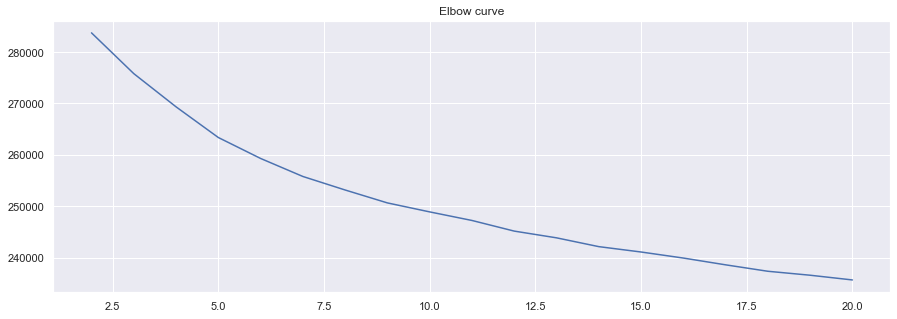

In [60]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, k_hp_max+1), distortions)
plt.grid(True)
plt.title('Elbow curve');

### Visualize cluster homogenity

In [135]:
# determine ideal number of clusters from plot
k_opt = 6
kmeans_opt = KMeans(n_clusters=k_opt).fit(X_train_red)

In [136]:
df_kmeans = pd.DataFrame({'cluster':kmeans_opt.labels_, 'Region':y_train})

df_kmeans_sizes = df_kmeans.groupby(by=["cluster", "Region"]).size().to_frame(name="count")

df_kmeans_totals = df_kmeans.groupby(by=["cluster"]).size()
totals = dict(zip(df_kmeans_totals.index.tolist(), df_kmeans_totals.values))

# map cluster totals to df and calculate relative occurence count
df_kmeans_sizes["totals"] = 0
for i in range(k_opt):
    df_kmeans_sizes.loc[i].totals = totals[i]
    
df_kmeans_sizes["rel. count (%)"] = (df_kmeans_sizes["count"]/df_kmeans_sizes["totals"])*100

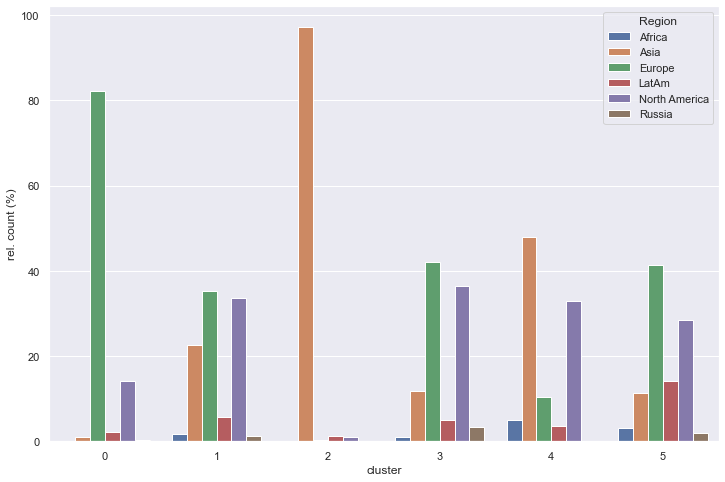

In [137]:
# visualize homogenity / distribution of clusters and original labels
sns.barplot(x="cluster", y="rel. count (%)", hue="Region", data=df_kmeans_sizes.reset_index());

In [161]:
# print top k frequent ingredients for asian and european cluster
k_ing = 10
cluster_europe = 0
cluster_asia = 2

for i in range(k_opt):
    cluster_i = [kmeans_opt.labels_ == i]
    top_k_i = np.argpartition(X_train[tuple(cluster_i)].sum(axis=0), -k_ing)[-k_ing:] # https://stackoverflow.com/questions/6910641
    print("Cluster {:.0f} most frequent ingredients:\n".format(i), df_train.iloc[0, top_k_i].index.values)

Cluster 0 most frequent ingredients:
 ['parsley' 'tomatoes' 'salt' 'cheese' 'pepper' 'red' 'mi' 'butter'
 'garlic' 'olive oil']
Cluster 1 most frequent ingredients:
 ['sugar' 'olive oil' 'mi' 'red' 'water' 'salt' 'oil' 'ice' 'juice'
 'garlic']
Cluster 2 most frequent ingredients:
 ['red' 'water' 'gin' 'pepper' 'salt' 'garlic' 'oil' 'soy' 'sesame' 'sugar']
Cluster 3 most frequent ingredients:
 ['cream' 'baking powder' 'large eggs' 'butter' 'salt' 'flour' 'mi' 'extra'
 'sugar' 'water']
Cluster 4 most frequent ingredients:
 ['gin' 'juice' 'salt' 'chili' 'pepper' 'onions' 'red' 'mi' 'oil' 'garlic']
Cluster 5 most frequent ingredients:
 ['oil' 'mi' 'onions' 'salt' 'tomatoes' 'garlic' 'ice' 'red' 'olive oil'
 'pepper']
